# Titanic data analysis
We analyze here the *titanic-data.csv* dataset with the help of several python libraries: *pandas* & *numpy* for data management, *bokeh* for plotting, *scipy.stats* for t-test computation.

We intend to investigate the following questions with the help of this analysis:
- Did **gender** had an impact on survival ? In other words, was it easier to survive the shipwreck if you were a **woman** (maybe because of priority access to lifeboats) or if you were a **man** (maybe be because you could use your force during crowd movements) ?
- Did **social status** had an impact on survival ? In other words, was it easier to survive the shipwreck if you were richer (higher **fare**, higher **class**) than the mean (maybe because of a greater attention from the crew to get you to the lifeboats) ?
- Did **age** had an impact on survival ? In other words, was it easier to survive the shipwreck if you were **young** enough to be given priority access to lifeboats ?

## Data selection & feature creation
Several treatments are done:
- We select only the columns which we find useful for our analysis: 
    - 'Sex' to analyze the impact of **gender**
    - 'Fare' & 'Pclass' to analyze the impact of **social status**
    - 'Age' to analyze the impact of **youngness**
- We create a new categorical feature 'Young' from the numerical feature 'Age': you are 'Young' if your 'Age' is below or equal to 16 (we'll see later how we chose this threshold).

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

# load data
filename = 'titanic-data.csv'
df_raw = pd.read_csv(filename)

# clean Age & Fare columns
col_to_analyze = ['Pclass', 'Sex', 'Age', 'Fare']
df = (
    df_raw
    .loc[:, col_to_analyze + ['Survived']]
    .assign(Youngness=lambda df: (df.Age <= 16).map({True: 'Below 16', False: 'Above 16'}))
    .assign(Survival=lambda df: df.Survived.map({0: 'Died', 1: 'Survived'}))
    .assign(Class=lambda df: df.Pclass.map({1: '1st Class', 2: '2nd Class', 3: '3rd Class'}))
    .sort_values(by=['Class', 'Survived'])
)
df.count()

Pclass       891
Sex          891
Age          714
Fare         891
Survived     891
Youngness    891
Survival     891
Class        891
dtype: int64

## Handling of missing data in 'Age' columns:
- We decide to keep all records which don't have 'Age' data and be careful with our computations when we will analyze this feature. We don't decide to do any imputation. In the algorithms used in the followup (Chi Squared test), it is equivalent to drop the records which have no data (the sample size is dynamically recomputed inside those functions). This is like doing a **listwise deletion** (one of the options proposed in this site: https://measuringu.com/handle-missing-data/).

_Note: listwise deletion is the easiest way to deal with missing data, but another solution would be doing a multilinear regression to do a value imputation. However, in this context, it would be require more attention and would not help the interpretation of the final results using the Age feature. I prefer using "raw" data (and deleting missing values and being aware that my dataset is slightly different if I'm using the 'Age' feature) than doing an incorrect imputation._

## Data plotting


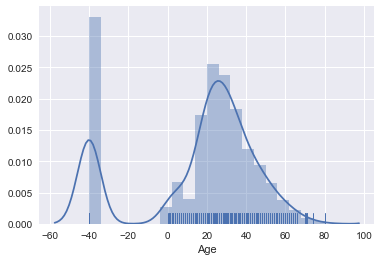

In [4]:
g = sns.distplot(
    df.Age.fillna(-40),
    rug=True
)

- With the help of the method `fillna`, I have done an imputation to the missing Age data. All missing ages are set to -40, which is obviously not a real age. I Have done that to try to see how much data is missing compared to the rest.

- We see that missing Age data represent a non negligible proportion of the data, as we can see it on the kernel density estimation plot.

- We see that Age is a slightly right-skewed distribution 

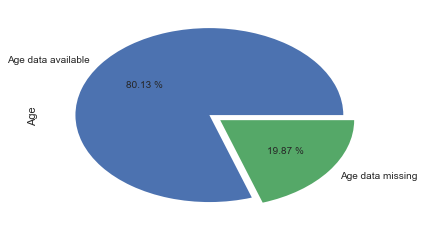

In [5]:
g = (
    df.Age
    .isnull()
    .map({False: 'Age data available', True: 'Age data missing'})
    .value_counts()
    .plot.pie(autopct='%.2f %%', explode=(0, 0.1))
)

This pie chart allows us to see more clearly the proportion of Age data which is missing: roughly 20 %.

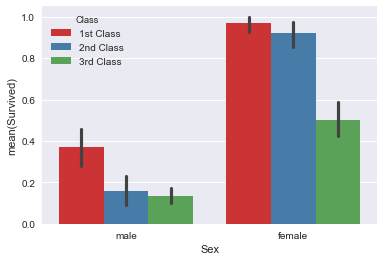

In [7]:
# Survival rate as a function of Pclass and Sex
g = sns.barplot(
    data=df,
    x='Sex',
    y='Survived',
    hue='Class', 
    palette='Set1',
)

- We see that 'Sex' (gender) seems to have a high influence on survival rate: being a woman seems to increase survival rate. 
- We see that 'Class' (passenger class) seems to have some influence on survival rate: being in 1<sup>st</sup> class seems to increase survival rate.
- Those effects seems to combine themselves:
    - Being a poor or middle-class (Class = 2<sup>nd</sup> or 3<sup>rd</sup>) male seems to decrease drastically your survival rate.
    - Being a rich or middle-class (Class = 1<sup>st</sup> or 2<sup>nd</sup>) female seems to increase drastically your survival rate.
    
_Now let's dive deeper_

_**For the next plots, we will use the 'Age' feature. The records with a missing 'Age' value won't be plotted (like if we did a listwise deletion).**_ 

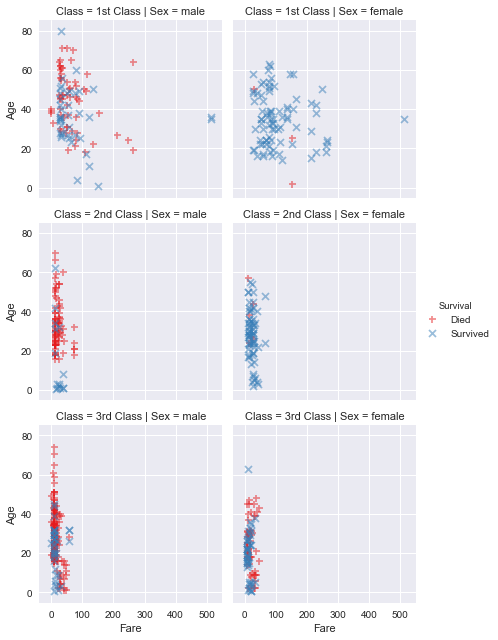

In [8]:
# Individuals and their survival status as a function of the Fare they paid and their age, for various categories (Pclass & Sex)
g = sns.FacetGrid(
    df,
    col='Sex',
    row='Class',
    hue='Survival', 
    hue_kws={'marker': ['+', 'x']},
    palette='Set1',
)
g.map(plt.scatter, 'Fare', 'Age', alpha=.5)
g.add_legend()


This plot confirms the influence of gender and social status on survival rate:
- Class = 2<sup>nd</sup> or 3<sup>rd</sup>; Sex = female: majority of survival
- Class = 1<sup>st</sup> or 2<sup>nd</sup>; Sex = male: majority of death

However, due to scale, this plot is not really precise on Class = 2<sup>nd</sup> or 3<sup>rd</sup>. Let's redraw it for those classes.

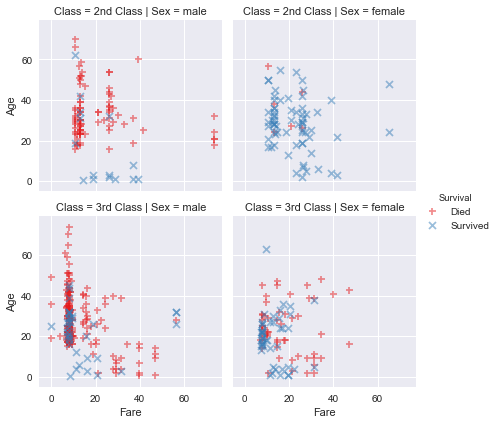

In [9]:
g = sns.FacetGrid(
    df[df.Pclass != 1],
    col='Sex',
    row='Class',
    hue='Survival', 
    hue_kws={'marker': ['+', 'x']},
    palette='Set1',
)
g.map(plt.scatter, 'Fare', 'Age', alpha=.5)
g.add_legend()


From these plots, we identify an Age threshold: if your Age is below or equal to 16, the surival rate seems to increase.

_That's how we chose the threshold to create the 'Youngness' feature._

Let's try to plot again the barplot from the beginning to see more clearly the impact of this 'Young' feature.

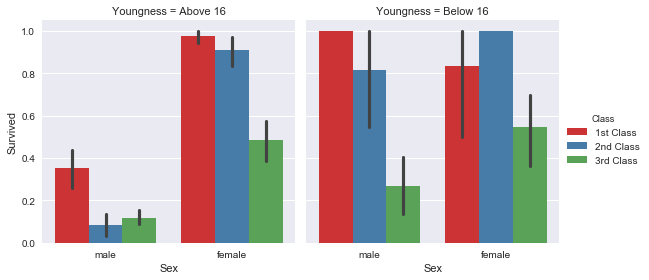

In [10]:
g = sns.factorplot(
    data=df,
    x='Sex',
    y='Survived',
    col='Youngness',
    hue='Class', 
    palette='Set1',
    kind='bar',
)


We understand that being 'Young' has a high impact on male survival rate. This effect is especially important for Class = 1<sup>st</sup> or 2<sup>nd</sup>. In other words, rich or middle-class young boys had a much better survival rate than grown-up men (especially those which were middle-class or poor).

_Note: we don't see an important impact on survival rate of females, because the survival rate is pretty high for all females. It seems that nearly all women were rescued in priority, regardless of their age._

## Data analysis: chi<sup>2</sup> test
We compute various chi<sup>2</sup> test on categorical data for the following alternative hypotheses: 
- Class has a significant effect on Survival
- Youngness has a significant effect on Survival

In [12]:
# Chi-Squared Tests
def apply_chi2_contingency_and_print_results(df, independent_variable, dependent_variable, alpha=0.05):
    from scipy.stats import chi2_contingency
    # Pclass to Survivability
    pivot = (
        df[[dependent_variable, independent_variable]]
        .pipe(
            pd.pivot_table,
            index = dependent_variable,
            columns = independent_variable,
            aggfunc = len
        )
    )
    chi2, p_value, dof, expected = chi2_contingency(pivot)
    print("Chi-Squared test on {} to {}.".format(independent_variable, dependent_variable))
    print("Does {} have a significant effect on {}?".format(independent_variable, dependent_variable))
    print("chi2 score: {:.2e} | p value: {:.2e}".format(chi2, p_value))
    print('Null hypothesis is {maybe}rejected: {} and {} are {maybe}correlated.'
          .format(independent_variable, dependent_variable, maybe='' if p_value < alpha else 'not '))
    print()

In [14]:
alpha = 0.05
apply_chi2_contingency_and_print_results(df, 'Class', 'Survival', alpha=0.05)
apply_chi2_contingency_and_print_results(df, 'Youngness', 'Survival', alpha=0.05)
apply_chi2_contingency_and_print_results(df, 'Sex', 'Survival', alpha=0.05)


Chi-Squared test on Class to Survival.
Does Class have a significant effect on Survival?
chi2 score: 1.03e+02 | p value: 4.55e-23
Null hypothesis is rejected: Class and Survival are correlated.

Chi-Squared test on Youngness to Survival.
Does Youngness have a significant effect on Survival?
chi2 score: 1.24e+01 | p value: 4.36e-04
Null hypothesis is rejected: Youngness and Survival are correlated.

Chi-Squared test on Sex to Survival.
Does Sex have a significant effect on Survival?
chi2 score: 2.61e+02 | p value: 1.20e-58
Null hypothesis is rejected: Sex and Survival are correlated.



# Conclusion
It has to be noted that the titanic had officially ~1300 passengers & ~900 crew members on board (according to wikipedia & Larousse Encyclopedia) so it might be possible that the sample dataset (819 people) does not cover properly the population on board at that moment.  

Various data vizualization and statistical test allowed us to understand the influence of **gender**, **social status** and **youngness** on survival rate during the Titanic shipwreck. On one hand, the operational definition of gender is obvious, on the other hand, after several investigations with vizualizations, we chose the following operational definitions for youngness:
- Young means Age below or equal to 16

We have seen on charts that:
- rich or middle-class (young) girls & (not young) women were more likely to survive
- rich or middle-class (young) boys were more likely to survive
- poor or middle-class (not young) men were more likely to die

We have tested statistically that:
- Class and Survival are correlated
- Youngness and Survival are correlated
- Sex and Survival are correlated

It has to be noted that, since roughly 20% of records (~100 records) were missing the 'Age' data, those records have been discarded to study the hypothesis related to age/youngness. This is a limitation of this study. This brings attention to the second hypothese, which may be a noisy prediction: maybe there are enough rich/middle-class boys who died in the "dropped records" to change the conclusion of the chi<sup>2</sup> test.

_We'll never know. :)_

Given the limitations (dataset not covering the whole population, missing Age data): I would not publish the results of the statistical tests. It might some spurious correlation (even if it is easy to find a compelling argument in favor of such correlation).

That said, I would have liked to have a plan of the Titanic to see if the minimum distance from each Cabin to the nearest lifeboat had an influence on Survival. 